In [ ]:
#Nota:
#o código abaixo foi adaptado para rodar no jupyter lab.
#as linhas referentes ao Streamlit foram comentadas

# Install

In [ ]:
#!pip install -q yfinance
#!pip install -q cufflinks
#!pip install -q ta
#!pip install -q -U kaleido #para salvar o gráfico em imagem estática

# Import

In [1]:
#import streamlit as st
import yfinance as yf #para baixar preços dos ativos
from datetime import datetime, timedelta
import requests
import pandas as pd
import numpy as np
import math

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ta
#from ta.momentum import StochasticOscillator

import cufflinks as cf
import plotly.express as px
import plotly.io as pio 


import ipywidgets as widgets

# Funções

In [2]:
#calcular as 6 datas necessárias
def list_useful_dates(reference_date):
    useful_dates = []
    useful_dates.append(reference_date - timedelta(days=1)) #1 dia antes
    for i in range(1, 6): #6 = 5 datas +1, exclusive
        # Calcula a nova data baseada na data de referência e no espaçamento de 30 dias
        new_date = reference_date - timedelta(days=i * 30)        
        useful_dates.append(new_date)
    return useful_dates

In [3]:
#verificar se as datas calculadas são válidas
def verifica_datas(result, lista_data):
    print("calculando as datas úteis...")
    for entry in result:
        z = entry
        zz = z + timedelta(days=1)        
    
        while True:
            data1 = pd.DataFrame(yf.download('VALE3.SA', start=z, end=zz, progress=False)['Adj Close'])
            
            if data1.shape[0] > 0:
                lista_data = pd.concat([lista_data, data1])
                break  # Saia do loop interno se os dados foram baixados com sucesso
                
            print(f'{data1.shape[1]} datas válidas')
            new_date_z = z - timedelta(days=1)
            new_date_zz = new_date_z + timedelta(days=1)
            print("Data inválida. Obtendo novos valores...")
                        
            z = new_date_z
            zz = new_date_zz    
    return(lista_data)
    print("datas ok!")

In [4]:
#restrições definidas para seleção dos ativos
volume_min = 200_000
preco_min = 3

#função para baixar nomes dos ativos
def dados_brapi():
    r = requests.post('https://brapi.dev/api/quote/list?sortBy=name')
    res = r.json() #transforma em dados legiveis
    global df #pra poder usar fora da função
    df = pd.DataFrame.from_dict(res['stocks']) #cria dataframe a partir da key do dict da lista 'res'
    df = df[ (df['volume'] > volume_min) &  (df['close'] > preco_min) ]
    return df

In [5]:
#função para criar lista de ativos para usar no yfinance
def lista():
    sfx = '.SA'
    acoess = df2['stock'].apply(lambda x: f"{x}{sfx}").values.tolist()
    return acoess

In [6]:
#função para baixar os preços dos ativos com yfinance
def baixa():
    data_yf = yf.download(acoess, start=inicio, end=fim, progress=False)['Adj Close'] #só a coluna que interessa
    return data_yf

In [7]:
#função para calcular o fator de ponderação
def calcular_resultado(row):    
    varx5 = (row.iloc[1] / row.iloc[6]) - 1 #lembrando que o mês 5 está na coluna 1
    varx4 = (row.iloc[2] / row.iloc[6]) - 1 #lembrando que o mês 4 está na coluna 2
    varx3 = (row.iloc[3] / row.iloc[6]) - 1 #lembrando que o mês 3 está na coluna 3
    varx2 = (row.iloc[4] / row.iloc[6]) - 1 #lembrando que o mês 2 está na coluna 4
    varx1 = (row.iloc[5] / row.iloc[6]) - 1 #lembrando que o mês 1 está na coluna 5
    return (varx5*math.sqrt(5) + varx4*math.sqrt(4) + varx3*math.sqrt(3) + varx2*math.sqrt(2) + varx1*math.sqrt(1) ) / 8.382

In [8]:
#função para verificar o indicador MACD
def calcula_macd():            
    for simbolo, dadosx in todos_dados.items():
        p = dadosx.iloc[-1]  # ultimo preço
        macd = ta.trend.macd(dadosx)
        # verifica se macd está ascendente ou descendente
        if macd.iloc[-1] > 0 and macd.iloc[-1] > macd.iloc[-2]:         
            print(f'{simbolo}: MACD positivo ascendente, R${p}') #pra mostrar o preço também

In [9]:
#função para baixar os dados da lista para criar o gráfico
def baixa_lista():    
    bleh = yf.download(lista, start=inicio, end=fim, progress=True)        
    return bleh

## Data de Referência

In [ ]:
# reference_date = st.date_input("Digite a data de referência:")

# if reference_date:    
#     result = list_useful_dates(reference_date)    

In [10]:
# Variável global para armazenar a data selecionada
reference_date = None

# Cria um DatePicker
date_picker = widgets.DatePicker(
    description='Selecione uma data:',
    disabled=False
)

# Função para obter a data selecionada
def get_selected_date(change):
    global reference_date
    reference_date = change['new']
    
# Conecta a função ao evento de mudança do DatePicker
date_picker.observe(get_selected_date, names='value')

# Exibe o DatePicker
display(date_picker)

DatePicker(value=None, description='Selecione uma data:', step=1)

In [ ]:
print(reference_date)

In [11]:
if reference_date:    
    result = list_useful_dates(reference_date) 

In [ ]:
#check para debug
result

# Código

In [12]:
print(f"baixando dados de todos os ativos (volume mínimo de R\${volume_min:,.2f}, preço mínimo de R\${preco_min:.2f})")
df2 = dados_brapi()
df2 = df2[['stock', 'name', 'close', 'sector', 'volume']].sort_values(by='stock')
#retirar as que tem 11 no nome
# filter the rows that contain the substring
substring = '11'
filter = df2['stock'].str.contains(substring)
filtered_df = df2[~filter]
df2 = filtered_df
print("Obtidos os valores, excluindo ativos com '11'")

baixando dados de todos os ativos (volume mínimo de R\$200,000.00, preço mínimo de R\$3.00)
Obtidos os valores, excluindo ativos com '11'


In [ ]:
#check para debug
df2.head()

In [13]:
lista_data = pd.DataFrame(columns=['Adj Close'])

In [14]:
lista_data = verifica_datas(result, lista_data)

calculando as datas úteis...


C:\Users\bruno\AppData\Local\Temp\ipykernel_8772\4159870649.py:12: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.

C:\Users\bruno\AppData\Local\Temp\ipykernel_8772\4159870649.py:12: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


1 Failed download:
['VALE3.SA']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2024-03-03 -> 2024-03-04)')

1 Failed download:


$VALE3.SA: possibly delisted; No price data found  (1d 2024-03-03 -> 2024-03-04)
1 datas válidas
Data inválida. Obtendo novos valores...
$VALE3.SA: possibly delisted; No price data found  (1d 2024-03-02 -> 2024-03-03)


['VALE3.SA']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2024-03-02 -> 2024-03-03)')


1 datas válidas
Data inválida. Obtendo novos valores...


In [15]:
#check para debug
lista_data.shape

(6, 1)

In [16]:
acoess = lista() #ajustados os nomes dos ativos para uso no yfinance
        
inicio = lista_data.index[-1] #ultimo da lista
fim = lista_data.index[0] + timedelta(days=1) #1 dia a mais do primeiro da lista, exclusive

In [ ]:
#check para debug
print(len(acoess))
print(inicio)
print(fim)

In [17]:
data_yf = baixa() #baixa os preços de todos os ativos, no intervalo de 6 meses
data_yf.dropna(axis=1, inplace=True) #retira os vazios
dfxx = data_yf.loc[data_yf.index.isin(lista_data.index)]   


1 Failed download:
['BBAS3F.SA']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


In [ ]:
#check para debug
dfxx.head()

In [18]:
print("ajustando o dataframe...")
teste2 = dfxx.copy()
teste2.index = pd.to_datetime(teste2.index).strftime('%d-%m-%Y')
teste2 = teste2.round(decimals = 2)
df_pivot = teste2.T #para transpor

ajustando o dataframe...


In [ ]:
#check para debug
df_pivot.head()

In [19]:
df_pivot = df_pivot.reset_index()
df_pivot = df_pivot.rename(columns={'Ticker': 'ação'})
# if df_pivot.shape[1] > 7:
#     df_pivot = df_pivot.drop(df_pivot.columns[1], axis=1)
print("dataframe ajustado!")

dataframe ajustado!


In [ ]:
#check para debug
df_pivot.head()

In [20]:
print("calculando o fator de ponderação...")
df_pivot['Ponderado'] = df_pivot.apply(lambda row: calcular_resultado(row), axis=1)
print("ponderação calculada!")

calculando o fator de ponderação...
ponderação calculada!


In [ ]:
#check para debug
df_pivot.head()

In [21]:
print("calculando o FR...")
df_pivot = df_pivot.sort_values(by='Ponderado', ignore_index=False) #tem que colocar em ordem crescente de ponderado primeiro
df_pivot['C'] = np.arange(df_pivot.shape[0]) #cria uma coluna com o numero da linha
df_pivot['FR'] = ( ( df_pivot.shape[0] - df_pivot['C']   ) /df_pivot.shape[0] ) * 100 #total de linhas - num da linha / total de linhas
df_pivot = df_pivot.sort_values(by='FR', ascending=False, ignore_index=False) #classifica por FR em ordem decrescente, sem descartar o índice

df_final = df_pivot[(df_pivot['FR'] >= 90)]
print("FR calculado!")

calculando o FR...
FR calculado!


In [ ]:
df_pivot

In [22]:
print("obtendo somente ações com FR > 90...")
new_df = df_pivot[['ação','FR']]
new_df = new_df.query('FR >= 90')
new_df.reset_index(inplace=True, drop=True) #drop joga fora a coluna com o index anterior    
# Adicionando uma nova coluna com o preço mais recente para cada ação em new_df
new_df['preço mais recente'] = new_df['ação'].apply(lambda x: dfxx[x].iloc[-1])
new_df.round(decimals = 3)

obtendo somente ações com FR > 90...


Date,ação,FR,preço mais recente
0,BIOM3.SA,100.000,17.50
1,CLSA3.SA,99.476,7.37
2,NVDC34.SA,98.953,120.20
3,CBAV3.SA,98.429,7.12
4,SYNE3.SA,97.906,9.39
5,EMBR3.SA,97.382,36.23
6,BRFS3.SA,96.859,18.58
7,JBSS3.SA,96.335,28.84
8,GOGL34.SA,95.812,75.60
9,GUAR3.SA,95.288,7.56


In [23]:
print("data de hoje:", reference_date.strftime("%d-%m-%Y"))
##análise do MACD das ações selecionadas
# Lista de símbolos de ações
lista = new_df['ação'].tolist()    
new_df2 = new_df.set_index('ação') #depois de gerar a lista
new_df2 = new_df2.round(decimals = 3)

#filtrar o data_yf só com as ações da lista
todos_dados = data_yf[lista]

data de hoje: 01-06-2024


In [ ]:
todos_dados

In [24]:
print(calcula_macd())

BIOM3.SA: MACD positivo ascendente, R$17.5
CLSA3.SA: MACD positivo ascendente, R$7.369999885559082
NVDC34.SA: MACD positivo ascendente, R$120.19999694824219
CBAV3.SA: MACD positivo ascendente, R$7.119999885559082
SYNE3.SA: MACD positivo ascendente, R$9.390000343322754
GUAR3.SA: MACD positivo ascendente, R$7.559999942779541
None


# Gráfico

In [25]:
##configuração do cufflinks    
cf.go_offline()
cf.set_config_file(world_readable=True, theme='white') 

In [ ]:
# choice = st.selectbox("escolha a ação", lista)    

In [26]:
# Variável global para armazenar a ação selecionada
choice = None

# Cria um grupo de radio buttons
radio_buttons = widgets.RadioButtons(
    options=lista,
    value=lista[0],
    description='Selecione uma opção:',
    disabled=False
)

# Função para obter o valor selecionado
def get_selected_value(change):
    global choice
    #print(f'Você selecionou: {change.new}')
    choice = change['new']

# Conecta a função ao evento de mudança de valor
radio_buttons.observe(get_selected_value, names='value')

# Exibe o widget
display(radio_buttons)

RadioButtons(description='Selecione uma opção:', options=('BIOM3.SA', 'CLSA3.SA', 'NVDC34.SA', 'CBAV3.SA', 'SY…

In [27]:
print(choice)

BIOM3.SA


In [28]:
bleh = baixa_lista()
dadosx = bleh.loc[:, (['Open', 'High', 'Low', 'Close', 'Volume'], choice)]
dadosx.columns = dadosx.columns.droplevel(1)

[*********************100%%**********************]  20 of 20 completed


In [29]:
#ajustes para novas versões do pandas, cufflinks e plotly
dadosx.index = dadosx.index.astype(str) #passar para string, pois não irá mais suportar datetime no índice

In [ ]:
type(dadosx)

In [30]:
pio.kaleido.scope.default_format = "svg"

C:\Users\bruno\miniconda3\envs\py311\Lib\site-packages\cufflinks\quant_figure.py:1061: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



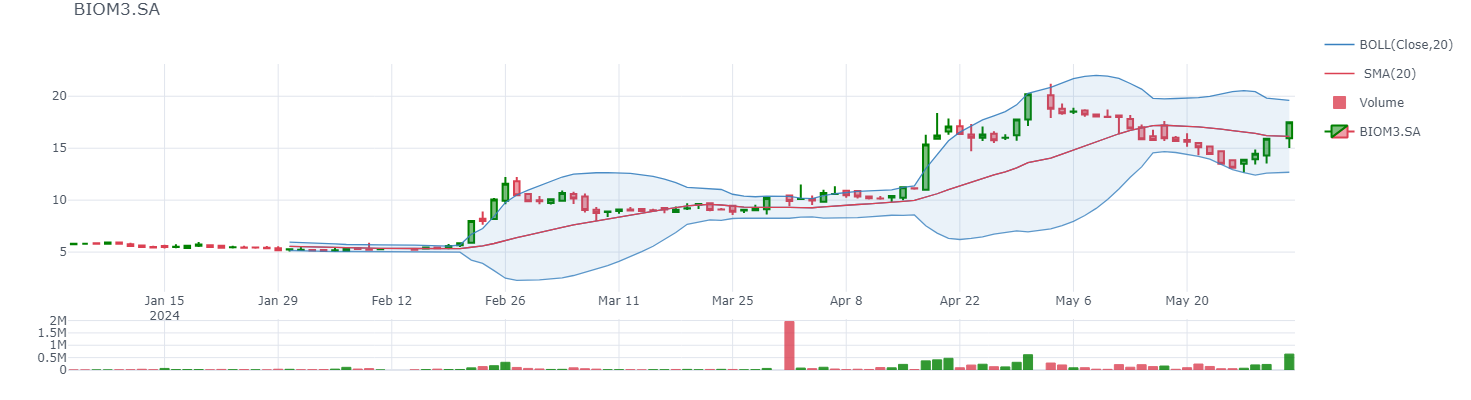

In [31]:
## grafico com o cufflinks
qf = cf.QuantFig(dadosx, kind='candlestick', name=choice, title=choice)
qf.add_bollinger_bands()
qf.add_sma(name='sma20', color='red')
qf.add_volume()    
fig = qf.iplot(asFigure=True, dimensions=(1000, 400), up_color='green', down_color='red')

##ajuste final do grafico
#update_xaxes ou update_yaxes é do plotly, que gera a fig
fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]), #hide weekends
    ]
)    
#st.plotly_chart(fig)
